In [39]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import feather

from sklearn.metrics import mean_squared_error, mean_absolute_error

from scipy import stats

from sklearn.linear_model import LinearRegression

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_offsets_noninterp.feather")
se = se.set_index(se.columns[0])

In [3]:
se = se.dropna(subset=['median_durations_by_segment_code_and_hour_and_day'])



In [4]:
se['prev_timingPoint'] = se['prev_timingPoint'].astype(float).astype(int)

In [5]:
# se.iloc[1978]

In [6]:
def filter_rare(stop_events):

    print("Calculating rare segments...")

    segment_counts = stop_events.groupby("segment_code").size()

    filtered_stop_events = stop_events.drop(
        stop_events[
            stop_events["segment_code"].isin(
                segment_counts[segment_counts < 120].index.values
            )
        ].index
    )

    print("\tCalculated")

    return filtered_stop_events

se = filter_rare(se)

Calculating rare segments...
	Calculated


In [7]:
def MAPE(forecast, actual):
    
    if(len(forecast) != len(actual)):
        raise ValueError('Could not calculate MAPE, forecast and actual arrays are different length')
        
    forecast = np.asarray(forecast)
    actual = np.asarray(actual)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        
        division = (actual-forecast)/actual
        
        division[actual == 0] = 0
        
        # Instead of dividing by n we count by the number of non-zero values. 
        # Essentially ignoring all cases where the actual value is zero. 
        mape = 100 / np.count_nonzero(actual) * np.sum(np.abs(division))
    
    return mape

In [8]:
def make_prediction(medians, results):
    return medians * (1 + (results / 100))




## Adding in a few more medians... why not

Starting by making some more medians to compare

In [9]:
se['dry'] = (se['rain'] == 0)
se['weekend'] = (se['arrival_day'] > 4)

In [102]:
segment_code_and_hour_and_daytype_groups = se[se["train"]].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

In [103]:
median_prev_dwell_by_segment_code_and_hour_and_daytype = (
    segment_code_and_hour_and_daytype_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [12]:
prev_stopCode_and_timing_point_groups = se[se["train"]].groupby(
    ["prev_stopCode", "prev_timingPoint"]
)

median_prev_dwell_by_prev_stop_code_and_timing_point = (
    prev_stopCode_and_timing_point_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_prev_stop_code_and_timing_point")
)

se = se.merge(
    median_prev_dwell_by_prev_stop_code_and_timing_point.to_frame(),
    "left",
    left_on=["prev_stopCode", "prev_timingPoint"],
    right_index=True,
)




In [13]:
segment_code_groups = se[se["train"]].groupby(
    ["segment_code"]
)

median_prev_dwell_by_segment_code = (
    segment_code_groups["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code")
)

se = se.merge(
    median_prev_dwell_by_segment_code.to_frame(),
    "left",
    left_on=["segment_code"],
    right_index=True,
)

In [15]:
se['diff_prev_dwell_and_median_by_segment_code_and_hour_and_daytype'] = se['dwell_duration_prev'] - se['median_prev_dwell_by_segment_code_and_hour_and_daytype']



In [16]:
segment_code_and_hour_and_daytype_groups = None
median_prev_dwell_by_segment_code_and_hour_and_daytype = None
prev_stopCode_and_timing_point_groups = None
median_prev_dwell_by_prev_stop_code_and_timing_point = None
segment_code_groups = None
median_prev_dwell_by_segment_code = None


In [17]:
def exclude_columns_containing(se, to_remove):

    min_cols = [c for c in se.columns if not any(x in c for x in to_remove)]

    se_min = se[min_cols]

    return se_min

In [18]:
se = exclude_columns_containing(se, ["prev_segment_code_",
            "next_segment_code_",
            "prev_event_index_",
            "next_event_index_",
            "offset_timestamp_5_", 
            "prev_stop_", 
            "next_stop_",
            "road"])

## Making up some rules

In [20]:
early_timing_points = se[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] + pd.Timedelta("1 minute") < se['prev_aimedArrival'])]

In [21]:
early_timing_points.shape[0]

75651

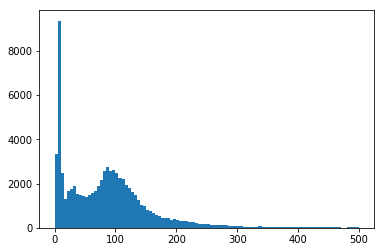

In [23]:
plt.hist(early_timing_points['dwell_duration_prev'], bins=100, range=(0,500));

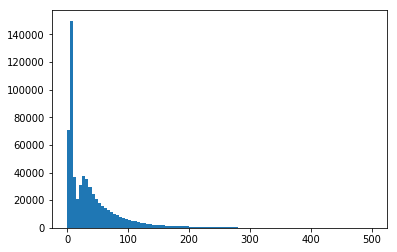

In [25]:
plt.hist(se.loc[se['prev_timingPoint'] == 1, 'dwell_duration_prev'], bins=100, range=(0,500));

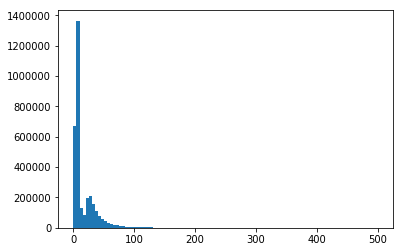

In [26]:
plt.hist(se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'], bins=100, range=(0,500));

In [70]:
buffers = []
median_dwells = []
mean_dwells = []

for extra in np.linspace(-20, 100, 13):
    dwells = se.loc[(se['prev_timingPoint'] == 1) & 
                    (se['prev_actualArrival'] + pd.Timedelta(f"{extra} second") < se['prev_aimedArrival']) &
                    (se['prev_actualArrival'] + pd.Timedelta(f"{extra + 10} second") > se['prev_aimedArrival']),
                        'dwell_duration_prev']
    
#     plt.hist(dwells, bins=100, range=(0,500));
#     plt.title(f"With {extra} seconds buffer")
#     plt.show()
    print(f"With {extra} seconds buffer")
    print(f"Length: {len(dwells):,}")
    print(f"Mean: {np.mean(dwells)}")
    print(f"Median: {np.median(dwells)}")
    print(f"----------------------------------")
    
    buffers.append(extra)
    median_dwells.append(np.median(dwells))
    mean_dwells.append(np.mean(dwells))
    

With -20.0 seconds buffer
Length: 24,522
Mean: 24.81229100399641
Median: 9.0
----------------------------------
With -10.0 seconds buffer
Length: 24,692
Mean: 27.768751012473675
Median: 14.0
----------------------------------
With 0.0 seconds buffer
Length: 22,717
Mean: 32.10454725535942
Median: 20.0
----------------------------------
With 10.0 seconds buffer
Length: 19,469
Mean: 38.94724947352201
Median: 28.0
----------------------------------
With 20.0 seconds buffer
Length: 16,762
Mean: 44.64819233981625
Median: 35.0
----------------------------------
With 30.0 seconds buffer
Length: 15,672
Mean: 49.59558448187851
Median: 43.0
----------------------------------
With 40.0 seconds buffer
Length: 15,003
Mean: 53.929814037192564
Median: 49.0
----------------------------------
With 50.0 seconds buffer
Length: 13,555
Mean: 60.404131316857246
Median: 58.0
----------------------------------
With 60.0 seconds buffer
Length: 11,706
Mean: 66.91653852725098
Median: 68.0
------------------------

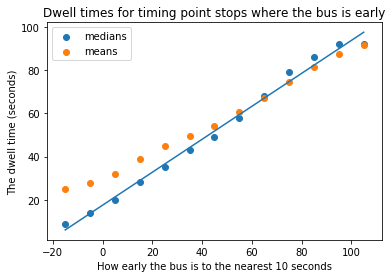

In [71]:
buffers = np.array(buffers).reshape(-1, 1) + 5

plt.scatter(buffers, median_dwells, label="medians")
plt.scatter(buffers, mean_dwells, label="means")

reg = LinearRegression()

reg.fit(buffers, median_dwells)

plt.plot(buffers, reg.predict(buffers))
plt.legend()
plt.title("Dwell times for timing point stops where the bus is early")
plt.xlabel("How early the bus is to the nearest 10 seconds")
plt.ylabel("The dwell time (seconds)")
plt.show()

In [49]:
# So we have a plan. 
# For all non-timing point dwells we do the normal thing (median per stop/segment, hour of the day and day type)
# For all timing points that are late we do normal
# For all timing points that are early between 0 and 90 seconds we do a linear prediction
# For all timing points beyond 90 seconds late we predict 90 seconds
# Easy when you know how... :) 

# This means that we should only train on "normal and early stops"

In [50]:
MAPE(se['median_prev_dwell_by_segment_code_and_hour_and_daytype'], se['dwell_duration_prev'])

84.54421399956334

In [86]:
MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])


73.73389794875608

In [53]:
se['prev_dwell_type_normal'] = True

In [72]:
se.loc[(se['prev_timingPoint'] == 1) & (se['prev_actualArrival'] - pd.Timedelta("20 second") < se['prev_aimedArrival']), 'prev_dwell_type_normal'] = False


In [101]:
if 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal' in se.columns:
    se = se.drop(columns=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

segment_code_and_hour_and_daytype_groups_normal = se[(se["train"] == True) & (se['prev_dwell_type_normal'] == True)].groupby(
    ["segment_code", "arrival_hour", "weekend"]
)

median_prev_dwell_by_segment_code_and_hour_and_daytype_normal = (
    segment_code_and_hour_and_daytype_groups_normal["dwell_duration_prev"]
    .median()
    .rename("median_prev_dwell_by_segment_code_and_hour_and_daytype_normal")
)

se = se.merge(
    median_prev_dwell_by_segment_code_and_hour_and_daytype_normal.to_frame(),
    "left",
    left_on=["segment_code", "arrival_hour", "weekend"],
    right_index=True,
)

In [88]:
MAPE(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype'], se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'])


80.99478727149615

In [89]:
np.count_nonzero(np.isnan(se['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal']))

0

In [83]:
se = se.dropna(subset=['median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'])

In [90]:
MAPE(se.loc[se['prev_dwell_type_normal'], 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_dwell_type_normal'], 'dwell_duration_prev'])



78.69915299484994

In [91]:
MAPE(se.loc[se['prev_timingPoint'] == 0, 'median_prev_dwell_by_segment_code_and_hour_and_daytype_normal'], se.loc[se['prev_timingPoint'] == 0, 'dwell_duration_prev'])


73.73389794875608

In [117]:
earlies = se.loc[se['prev_dwell_type_normal'] == False, 'prev_aimedArrival'] - se.loc[se['prev_dwell_type_normal'] == False, 'prev_actualArrival']

earlies = earlies.astype('timedelta64[s]').values.reshape(-1, 1)


MAPE(reg.predict(earlies), se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'])


254.50294534533526

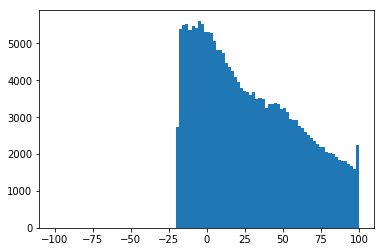

In [118]:
plt.hist(earlies, bins=100, range=(-100,100));

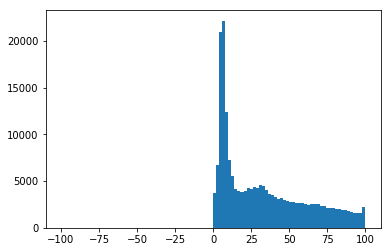

In [119]:
plt.hist(se.loc[se['prev_dwell_type_normal'] == False, 'dwell_duration_prev'], bins=100, range=(-100,100));

In [107]:
se['median_prev_dwell_by_segment_code_and_hour_and_daytype'] = se['median_prev_dwell_by_segment_code_and_hour_and_daytype_y']

In [108]:
se = se.drop(columns=['median_prev_dwell_by_segment_code_and_hour_and_daytype_y', 'median_prev_dwell_by_segment_code_and_hour_and_daytype_x'])